## Import

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, SimpleRNN
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

N_FEATURES = 51
TIMESTEPS = 1
DATASET_LINK = "3976184250-1655049260.csv"
TEST_DATA_LINK = "3976184250-1655049260-test.csv"

# random seed for reproducibility
SEED = 123

### LOAD DATASET
> * Check for class imbalance

In [3]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)
df['Subject'] = df['Subject'].str.replace('@yopmail.com','')
df['Subject'] = df['Subject'].str.replace('@gmail.com','')
df['Subject'] = df['Subject'].str.replace('alithnks','ali')

column_to_reorder = df.pop('Subject')

df.insert(0, 'Subject', column_to_reorder)

df.head()

,Subject,__id__,AvA,AvH,AvP,`DD.0.5`,`DD.1.6`,`DD.2.4`,`DD.4.8`,`DD.5.2`,...,`Size.9`,`UD.0.5`,`UD.1.6`,`UD.2.4`,`UD.4.8`,`UD.5.2`,`UD.6.7`,`UD.7.9`,`UD.8.1`,`UD.9.3`
0,aisha,32EyOh61auQrtt845qqu,30.386073,0.117320,0.207566,0.316371,0.525669,0.183837,0.574917,1.299633,...,29.588976,0.316371,0.525669,0.183837,0.574917,1.299633,0.333369,1.700769,0.949691,0.607718
1,aisha,4bA0GNx1E4csaTigdnUk,29.442656,0.117420,0.212496,0.349458,3.484031,0.219371,0.813483,0.342324,...,24.210612,0.349458,3.484031,0.219371,0.813483,0.342324,0.608039,0.625773,0.416927,0.908202
2,aisha,8XMHJ2b4PLrT9XU667dv,29.863961,0.098838,0.219027,0.282859,0.284138,0.192723,0.191222,0.224901,...,28.748535,0.282859,0.284138,0.192723,0.191222,0.224901,0.232967,0.466518,0.207866,0.426501
3,aisha,8eU5uqGw95a2Uao4QD08,31.369481,0.107199,0.287219,0.232834,0.208091,0.121858,0.141128,0.204205,...,27.236084,0.232834,0.208091,0.121858,0.141128,0.204205,0.183798,0.340828,0.183782,0.442837
4,aisha,AmDTWz3WvysQAblug2WG,30.882376,0.101829,0.261792,0.258754,0.216030,0.168339,0.590790,0.215137,...,29.588976,0.258754,0.216030,0.168339,0.590790,0.215137,0.226295,0.350204,0.192360,1.215338


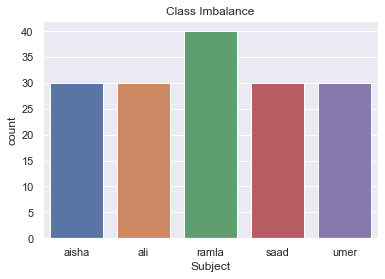

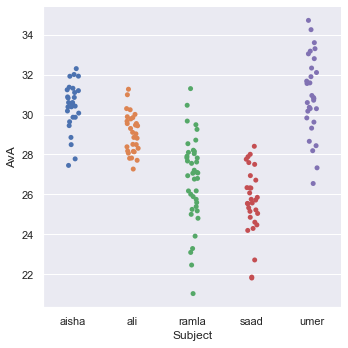

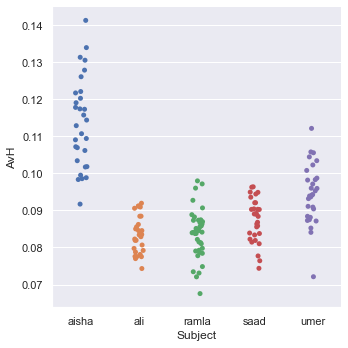

In [4]:
#################################
# # check for class imbalance # #
#################################

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=df).set_title("Class Imbalance")

# remove missing values if available
df = df.dropna()

sns.catplot(x="Subject", y="AvA", data=df)
sns.catplot(x="Subject", y="AvH", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [5]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,2:].astype(float)
Y = dataset[:,0]

# convert target Y to labelbinarizer Y for model
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

#################################
# # get all the encoded class # #
#################################
print("LabelBinarizer is able to decipher: ")
print(lb.classes_)
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

LabelBinarizer is able to decipher: 
['aisha' 'ali' 'ramla' 'saad' 'umer']


X dataset shape: (160, 51)
Y dataset shape: (160, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Normalisation performed based on X_train
> * Reshaping of dataset for LSTM Timesteps

In [6]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)


##############################################
# # normalisation and reshaping of dataset # #
##############################################
# normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
n_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (128, 1, 51)
Y train shape: (128, 5)
X test shape: (32, 1, 51)
Y test shape: (32, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [7]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(SimpleRNN(units=128, return_sequences=True, 
                 input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=100, 
                            batch_size=10)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable folds for kfold validation

2022-06-22 05:35:21.384394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 05:35:21.384394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
Epoch 1/100
7/7 [==============================] - 2s 4ms/step - loss: 2.0276 - accuracy: 0.2188 
Epoch 2/100
7/7 [==============================] - 2s 4ms/step - loss: 1.9872 - accuracy: 0.2188
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 2.0066 - accuracy: 0.3438
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 2.1107 - accuracy: 0.2812
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 1.7520 - accuracy: 0.2812
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 1.9344 - accuracy: 0.2969
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 1.7772 - accuracy: 0.4062
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 1.5217 - accuracy: 0.3594
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 1.7260 - accuracy: 0.3750
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 1.8386 - accuracy: 0.3750
Epoch 6/100
7/7 [

2022-06-22 05:35:29.657465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 05:35:29.657465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 05:35:29.657468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Epoch 1/100
Epoch 1/100
Epoch 1/100
9/9 [==============================] - 2s 3ms/step - loss: 2.0623 - accuracy: 0.2209
Epoch 2/100
Epoch 2/100
9/9 [==============================] - 2s 4ms/step - loss: 2.1350 - accuracy: 0.2118
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 1.8950 - accuracy: 0.2471
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 1.7970 - accuracy: 0.2907
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 1.8463 - accuracy: 0.3176
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 1.4381 - accuracy: 0.3412
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 1.7722 - accuracy: 0.3140
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 1.6032 - accuracy: 0.3529
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 1.3738 - accuracy: 0.5294
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 1.5161 - accuracy: 0

2022-06-22 05:35:40.926962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 05:35:40.927064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 05:35:40.927155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

4/4 [==============================] - 0s 1ms/step - loss: 0.9145 - accuracy: 0.7812
Epoch 1/100
Epoch 1/100
Epoch 1/100
10/10 [==============================] - 2s 3ms/step - loss: 2.2375 - accuracy: 0.2604
Epoch 2/100
10/10 [==============================] - 2s 4ms/step - loss: 2.4855 - accuracy: 0.1979 
Epoch 2/100
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 2.0547 - accuracy: 0.2292
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 1.8433 - accuracy: 0.3125
Epoch 3/100
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 1.8232 - accuracy: 0.2812
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 1.7518 - accuracy: 0.3229
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 1.7059 - accuracy: 0.3438
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 1.5906 - accuracy: 0.3333
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 1

2022-06-22 05:35:53.374303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 05:35:53.374441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 05:35:53.374543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

11/11 [==============================] - 0s 3ms/step - loss: 0.7950 - accuracy: 0.6569
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
11/11 [==============================] - 2s 4ms/step - loss: 1.9653 - accuracy: 0.3333
Epoch 2/100
11/11 [==============================] - 2s 4ms/step - loss: 2.0766 - accuracy: 0.2549
Epoch 2/100
11/11 [==============================] - 2s 4ms/step - loss: 2.1934 - accuracy: 0.1748
Epoch 2/100
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 1.8481 - accuracy: 0.3431
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 1.7332 - accuracy: 0.3725
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 1.7921 - accuracy: 0.2427
Epoch 3/100
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 1.7080 - accuracy: 0.4510
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 1.7983 - accuracy: 0.3204
Epoch 4/100
Epoch 4/100
11/11 [==============================

12/12 [==============================] - 0s 8ms/step - loss: 0.8489 - accuracy: 0.6518
Epoch 95/100
Epoch 98/100
12/12 [==============================] - 0s 8ms/step - loss: 0.8777 - accuracy: 0.7054
Epoch 91/100
Epoch 98/100
12/12 [==============================] - 0s 9ms/step - loss: 0.8448 - accuracy: 0.6786
Epoch 85/100
Epoch 85/100
Epoch 99/100
Epoch 99/100
Epoch 96/100
Epoch 86/100
12/12 [==============================] - 0s 13ms/step - loss: 1.1689 - accuracy: 0.5804
Epoch 92/100
12/12 [==============================] - 0s 13ms/step - loss: 0.9755 - accuracy: 0.6250
Epoch 91/100
12/12 [==============================] - 0s 7ms/step - loss: 1.2326 - accuracy: 0.5804
Epoch 86/100
Epoch 100/100
12/12 [==============================] - 0s 9ms/step - loss: 0.9306 - accuracy: 0.6071
Epoch 100/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0658 - accuracy: 0.5179
Epoch 97/100
12/12 [==============================] - 0s 7ms/step - loss: 0.9724 - accuracy: 0.5893
Epoch

2/2 [==============================] - 1s 2ms/step - loss: 0.6853 - accuracy: 0.9286
> folds=9, accuracy=77.513% (min=46.667%, max=92.857%)


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
12/12 [==============================] - 4s 5ms/step - loss: 2.1038 - accuracy: 0.2174
Epoch 2/100
12/12 [==============================] - 4s 5ms/step - loss: 1.9825 - accuracy: 0.2261
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 1.6993 - accuracy: 0.3043
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 1.5118 - accuracy: 0.3130
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 1.5196 - accuracy: 0.4348
Epoch 4/100
12/12 [==============================] - 4s 7ms/step - loss: 2.2482 - accuracy: 0.1913
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 1.5462 - accuracy: 0.4087
Epoch 4/100
12/12 [==============================] - 0s 8ms/step - loss: 1.3631 - accuracy: 0.5217
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 1.9015 - accuracy: 0.2957
E

12/12 [==============================] - 0s 11ms/step - loss: 0.5415 - accuracy: 0.7913
Epoch 98/100
10/12 [========================>.....] - ETA: 0s - loss: 0.5070 - accuracy: 0.8300Epoch 99/100
Epoch 83/100
Epoch 96/100
Epoch 98/100
Epoch 94/100
12/12 [==============================] - 1s 66ms/step - loss: 0.4612 - accuracy: 0.8522
Epoch 99/100
12/12 [==============================] - 1s 69ms/step - loss: 0.5712 - accuracy: 0.8087
Epoch 95/100
12/12 [==============================] - 1s 74ms/step - loss: 0.4645 - accuracy: 0.8087
Epoch 99/100
12/12 [==============================] - 1s 71ms/step - loss: 0.4410 - accuracy: 0.8348
Epoch 95/100
12/12 [==============================] - 1s 73ms/step - loss: 0.4504 - accuracy: 0.8362
Epoch 95/100
12/12 [==============================] - 0s 9ms/step - loss: 0.7075 - accuracy: 0.7217
Epoch 84/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6341 - accuracy: 0.7913
Epoch 99/100
Epoch 97/100
12/12 [==========================

2/2 [==============================] - 1s 2ms/step - loss: 1.2837 - accuracy: 0.7692
> folds=10, accuracy=81.218% (min=69.231%, max=92.308%)


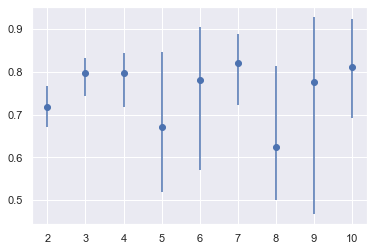

In [8]:
# from sklearn.model_selection import LeaveOneOut
def evaluate_kfold(X_train, y_train, SEED):
    
    # evaluate the model    
    folds = range(2,11)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
              (k, k_mean*100, k_min*100, k_max*100))
        
        # store mean accuracy
        means.append(k_mean)
        
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
evaluate_kfold(X_train, y_train, SEED)

##### generate kfold validation accuracy and loss

In [9]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    plt.show()
    
evaluate_kfold_model(X_train, y_train, SEED)

2022-06-22 05:37:40.686172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 281ms/step
Testing accuracy: 69.231%
1/1 [==============================] - 0s 275ms/step
Testing accuracy: 92.308%
1/1 [==============================] - 0s 253ms/step


ValueError: inconsistent shapes

##### perform actual KFold Validation

In [10]:
# create model
model = create_model()

n_folds = 2
kfold = KFold(n_splits=n_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

Epoch 1/100
7/7 [==============================] - 2s 2ms/step - loss: 2.2179 - accuracy: 0.1250
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 1.8931 - accuracy: 0.3750
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 1.6014 - accuracy: 0.3125
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 1.7839 - accuracy: 0.3281
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 1.5181 - accuracy: 0.4062
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 1.5559 - accuracy: 0.4531
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 1.5390 - accuracy: 0.4062
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 1.5484 - accuracy: 0.3906
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 1.3159 - accuracy: 0.5312
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 1.4240 - accuracy: 0.4375
Epoch 11/100
7/7 [===========

##### get validation accuracy

In [11]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

Validation Accuracy of 64.06% (with standard deviation of 0.00%)


### FIT MODEL FOR TESTING 
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [12]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=1)
history = model.fit(X_train, y_train, callbacks=es, verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 3ms/step - loss: 2.1277 - accuracy: 0.1875
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 1.8893 - accuracy: 0.2656
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 1.5219 - accuracy: 0.4375
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 1.3366 - accuracy: 0.4922
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 1.3406 - accuracy: 0.5156
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 1.2353 - accuracy: 0.5469
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 1.3134 - accuracy: 0.4922
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 1.1785 - accuracy: 0.5391
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 1.1085 - accuracy: 0.5703
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 1.0568 - accuracy: 0.6484
Epoch 11/

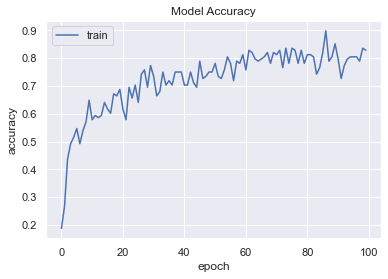

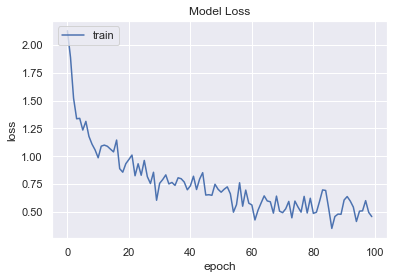

In [13]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
##########################
# # view model summary # #
##########################
model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 1, 128)            23040     
                                                                 
 dropout_15 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 128)           512       
 chNormalization)                                                
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 1, 128)            32896     
                                                                 
 dropout_16 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_16 (Bat  (None, 1, 128)           512       
 chNormalization)                                     

### MODEL TESTING
> * get model accuracy on the test dataset
> * generate confusion matrix
> * generate ROC curves
> * save the model if appropriate

In [15]:
y_pred = model.predict_proba(X_test)

# evaluate predictions
acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
print("Testing accuracy: %.3f%%" % (acc*100))

1/1 [==============================] - 0s 292ms/step
Testing accuracy: 75.000%


##### Confusion Matrix

<AxesSubplot:>

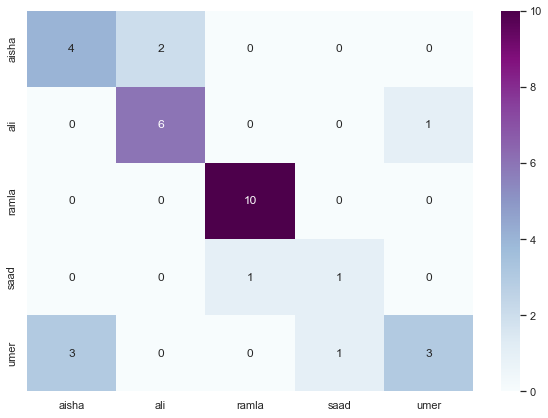

In [16]:
# confusion matrix
cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                     columns = [i for i in np.unique(lb.inverse_transform(y_test))])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

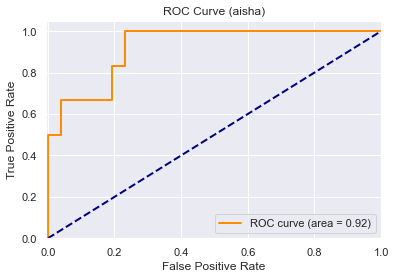

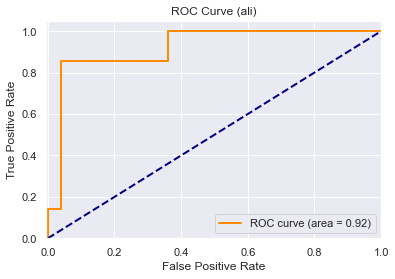

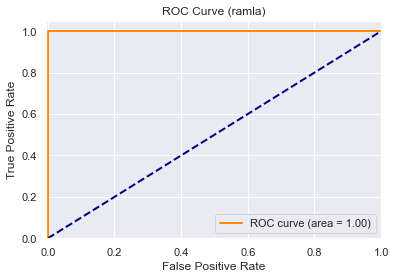

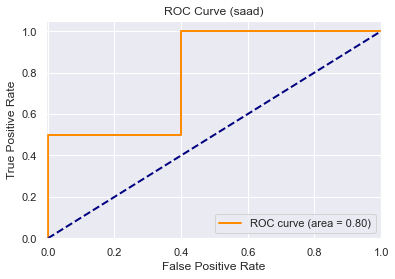

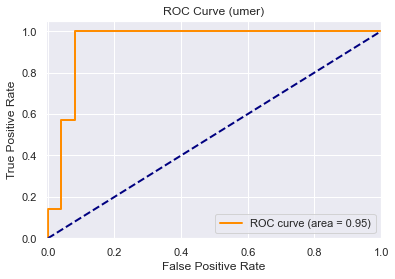

In [17]:
# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Combined Plot)

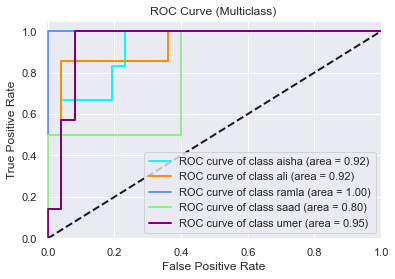

In [18]:
# compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

##### ROC Curve (Average out)

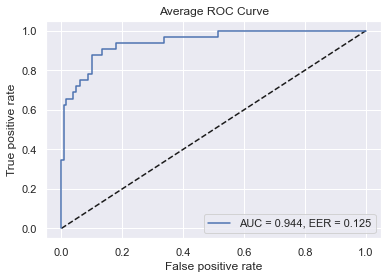

In [19]:
fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

# calculate equal-error-rate
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Average ROC Curve')
plt.legend(loc='best')
plt.show()

### FIT AND SAVE MODEL
> * fitting of model
> * get accuracy and loss of model
> * saving model

In [22]:
##############################################
# # normalisation and reshaping of dataset # #
##############################################
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df['Subject'] = df['Subject'].str.replace('@yopmail.com','')
df['Subject'] = df['Subject'].str.replace('@gmail.com','')
df['Subject'] = df['Subject'].str.replace('alithnks','ali')

column_to_reorder = df.pop('Subject')

df.insert(0, 'Subject', column_to_reorder)
df.head()
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,2:].astype(float)
Y = dataset[:,0]

# convert target Y to labelbinarizer Y for model
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

# # normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)


# reshaping the dataset to include LSTM Timesteps
X = np.asarray(X, dtype=np.float32)
X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

Epoch 1/100
16/16 [==============================] - 2s 6ms/step - loss: 2.0022 - accuracy: 0.3187
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 1.5531 - accuracy: 0.3875
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 1.3690 - accuracy: 0.5063
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 1.3730 - accuracy: 0.5063
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 1.2916 - accuracy: 0.4500
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 1.3149 - accuracy: 0.4875
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 1.2222 - accuracy: 0.5250
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 1.1156 - accuracy: 0.5312
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 1.1564 - accuracy: 0.5125
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 1.0873 - accuracy: 0.5312
Epoch 11/

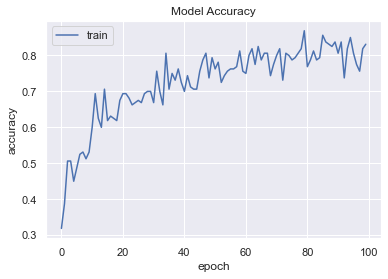

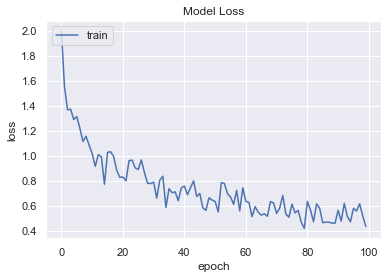

In [23]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### SAVE MODEL

In [24]:
##################
# # save model # #
##################

model.model.save("model/rnn_key_classifier.h5")

### LOAD MODEL

In [ ]:
# # ##################
# # # # load model # #
# # ##################

# model = create_model()
model = load_model("model/rnn_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [25]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df['Subject'] = pred_df['Subject'].str.replace('@yopmail.com','')
pred_df['Subject'] = pred_df['Subject'].str.replace('@gmail.com','')
pred_df['Subject'] = pred_df['Subject'].str.replace('alithnks','ali')

column_to_reorder = pred_df.pop('Subject')

pred_df.insert(0, 'Subject', column_to_reorder)
pred_df.head()

,Subject,__id__,AvA,AvH,AvP,`DD.0.5`,`DD.1.6`,`DD.2.4`,`DD.4.8`,`DD.5.2`,...,`Size.9`,`UD.0.5`,`UD.1.6`,`UD.2.4`,`UD.4.8`,`UD.5.2`,`UD.6.7`,`UD.7.9`,`UD.8.1`,`UD.9.3`
0,aisha,32EyOh61auQrtt845qqu,30.386073,0.117320,0.207566,0.316371,0.525669,0.183837,0.574917,1.299633,...,29.588976,0.316371,0.525669,0.183837,0.574917,1.299633,0.333369,1.700769,0.949691,0.607718
1,aisha,4bA0GNx1E4csaTigdnUk,29.442656,0.117420,0.212496,0.349458,3.484031,0.219371,0.813483,0.342324,...,24.210612,0.349458,3.484031,0.219371,0.813483,0.342324,0.608039,0.625773,0.416927,0.908202
2,aisha,8XMHJ2b4PLrT9XU667dv,29.863961,0.098838,0.219027,0.282859,0.284138,0.192723,0.191222,0.224901,...,28.748535,0.282859,0.284138,0.192723,0.191222,0.224901,0.232967,0.466518,0.207866,0.426501
3,ali,x1FEHtJP9xDxTOeMGxGD,29.888982,0.088453,0.324981,0.267652,0.215470,0.123510,0.207815,0.200449,...,27.667969,0.267652,0.215470,0.123510,0.207815,0.200449,0.117066,0.200477,0.143154,0.207918
4,ali,y5GzBnwpg43QOeOzQ28R,27.805260,0.077486,0.211683,0.233024,0.932978,0.163148,0.449982,0.194738,...,27.667969,0.233024,0.932978,0.163148,0.449982,0.194738,0.165819,0.199959,0.192599,0.201954


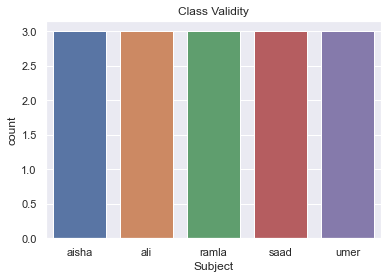

In [26]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [27]:
pred_dataset = pred_df.values

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[:,3:]

# print(pred_row)
############################
# # predict a single row # #
############################

pred_row=pred_df.iloc[1:,2:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
# pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

In [28]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict_proba(pred_arr)
pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

1/1 [==============================] - 0s 308ms/step
   Prediction    Accuracy
0        umer   0.5617309
1       aisha  0.44516447
2         ali  0.96479034
3         ali  0.97297704
4         ali    0.987648
5       ramla  0.99932885
6       ramla  0.99348515
7       ramla   0.9992853
8        saad   0.9970919
9        saad  0.99502254
10       saad  0.99801576
11       umer  0.97944194
12       umer  0.94787323
13       umer   0.9602694
